In [ ]:
# импортируем нужные библиотеки
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

import collections
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup
import random
import json
import re
import networkx as nx
import csv
import numpy as np

## Очистка данных

В этом разделе я буду использовать файл с ролями, который подготовила на прошлом шаге, только вручную очищенный от второстепенных героев. Задача этого раздела: убрать дубликаты, разночтения и лишние знаки. Подготовить словарь для визуализации сети в NetworkX. 

In [ ]:
#загружаем словарь со всеми персонажами из json
with open('marvel_movie_universe_heroes_main.json', 'r', encoding='utf-8') as fh: 
    test_dict_2 = json.load(fh)

In [ ]:
# проверяем, что в словаре есть данные о всех 23 фильмах киновселенной
print(len(test_dict_2))

23


In [ ]:
def removing_descriptions(list):

  example_str = ','
  
  for i in range(len(list)):
    if example_str in list[i]:
      list[i] = list[i][0:list[i].find(example_str)]

  return list

In [ ]:
def removing_cirill(list):

  regular_exp = '[а-яА-Я]+'

  for i in range(len(list)):
    list[i] = re.sub(regular_exp, '', list[i], count=0).strip()

  return list

In [ ]:
def get_unique_heroes(list_of_heroes):
  
  unique_heroes = []
  
  for hero in list_of_heroes:
    if hero in unique_heroes:
      continue
    else:
      unique_heroes.append(hero)
  
  return unique_heroes[1:]

In [ ]:
#загружаем словарь со всеми разночтениями из json
with open('marvel_movie_corrections.json', 'r', encoding='utf-8') as fh: 
    dict_corrections = json.load(fh)

In [ ]:
def remove_doubles(list, dict_corrections):

  for i in range(len(list)):
    for name, mist in dict_corrections.items():
      if list[i] in mist:
        list[i] = name
  
  return list

In [ ]:
# обновляем словарь, заменяя старые данные на очищенные
for film, cast in test_dict_2.items():
  test_dict_2[film] = get_unique_heroes(remove_doubles(removing_cirill(removing_descriptions(test_dict_2[film])), dict_corrections))

In [ ]:
#сохраняем словарь со всеми персонажами в json
with open('marvel_movie_universe_heroes_clean.json', 'w', encoding='utf-8') as fh: 
    fh.write(json.dumps(test_dict_2, ensure_ascii=False))

## Создание графа
Для создания финального файла героев для графа я воспользовалась функцией Counter, чтобы посчитать совместную встречаемость героев в фильмах и использовать в дальнейшем этот показатель как вес ребра. 

In [ ]:
# создаем список со списками героев из каждого фильма
ner_sents = []
for film, cast in test_dict_2.items():
  ner_sents.append(cast)

In [ ]:
# создаем список пар героев, чтобы потом посчитать их совместную встречаемость
pairs = []

for sent in ner_sents:
  if len(sent) > 1:
    for i in range(len(sent)-1):
      for j in range(i, len(sent)):
        if i != j:
          pair = (min(sent[i], sent[j]), max(sent[i], sent[j]))
          pairs.append(pair)

In [ ]:
# создаем граф из массива пар героев и их совместной встречаемости
g = nx.Graph((x, y, {'weight': v}) for (x, y), v in Counter(pairs).items())

(-0.95, 1.05, -1.0, 0.75)

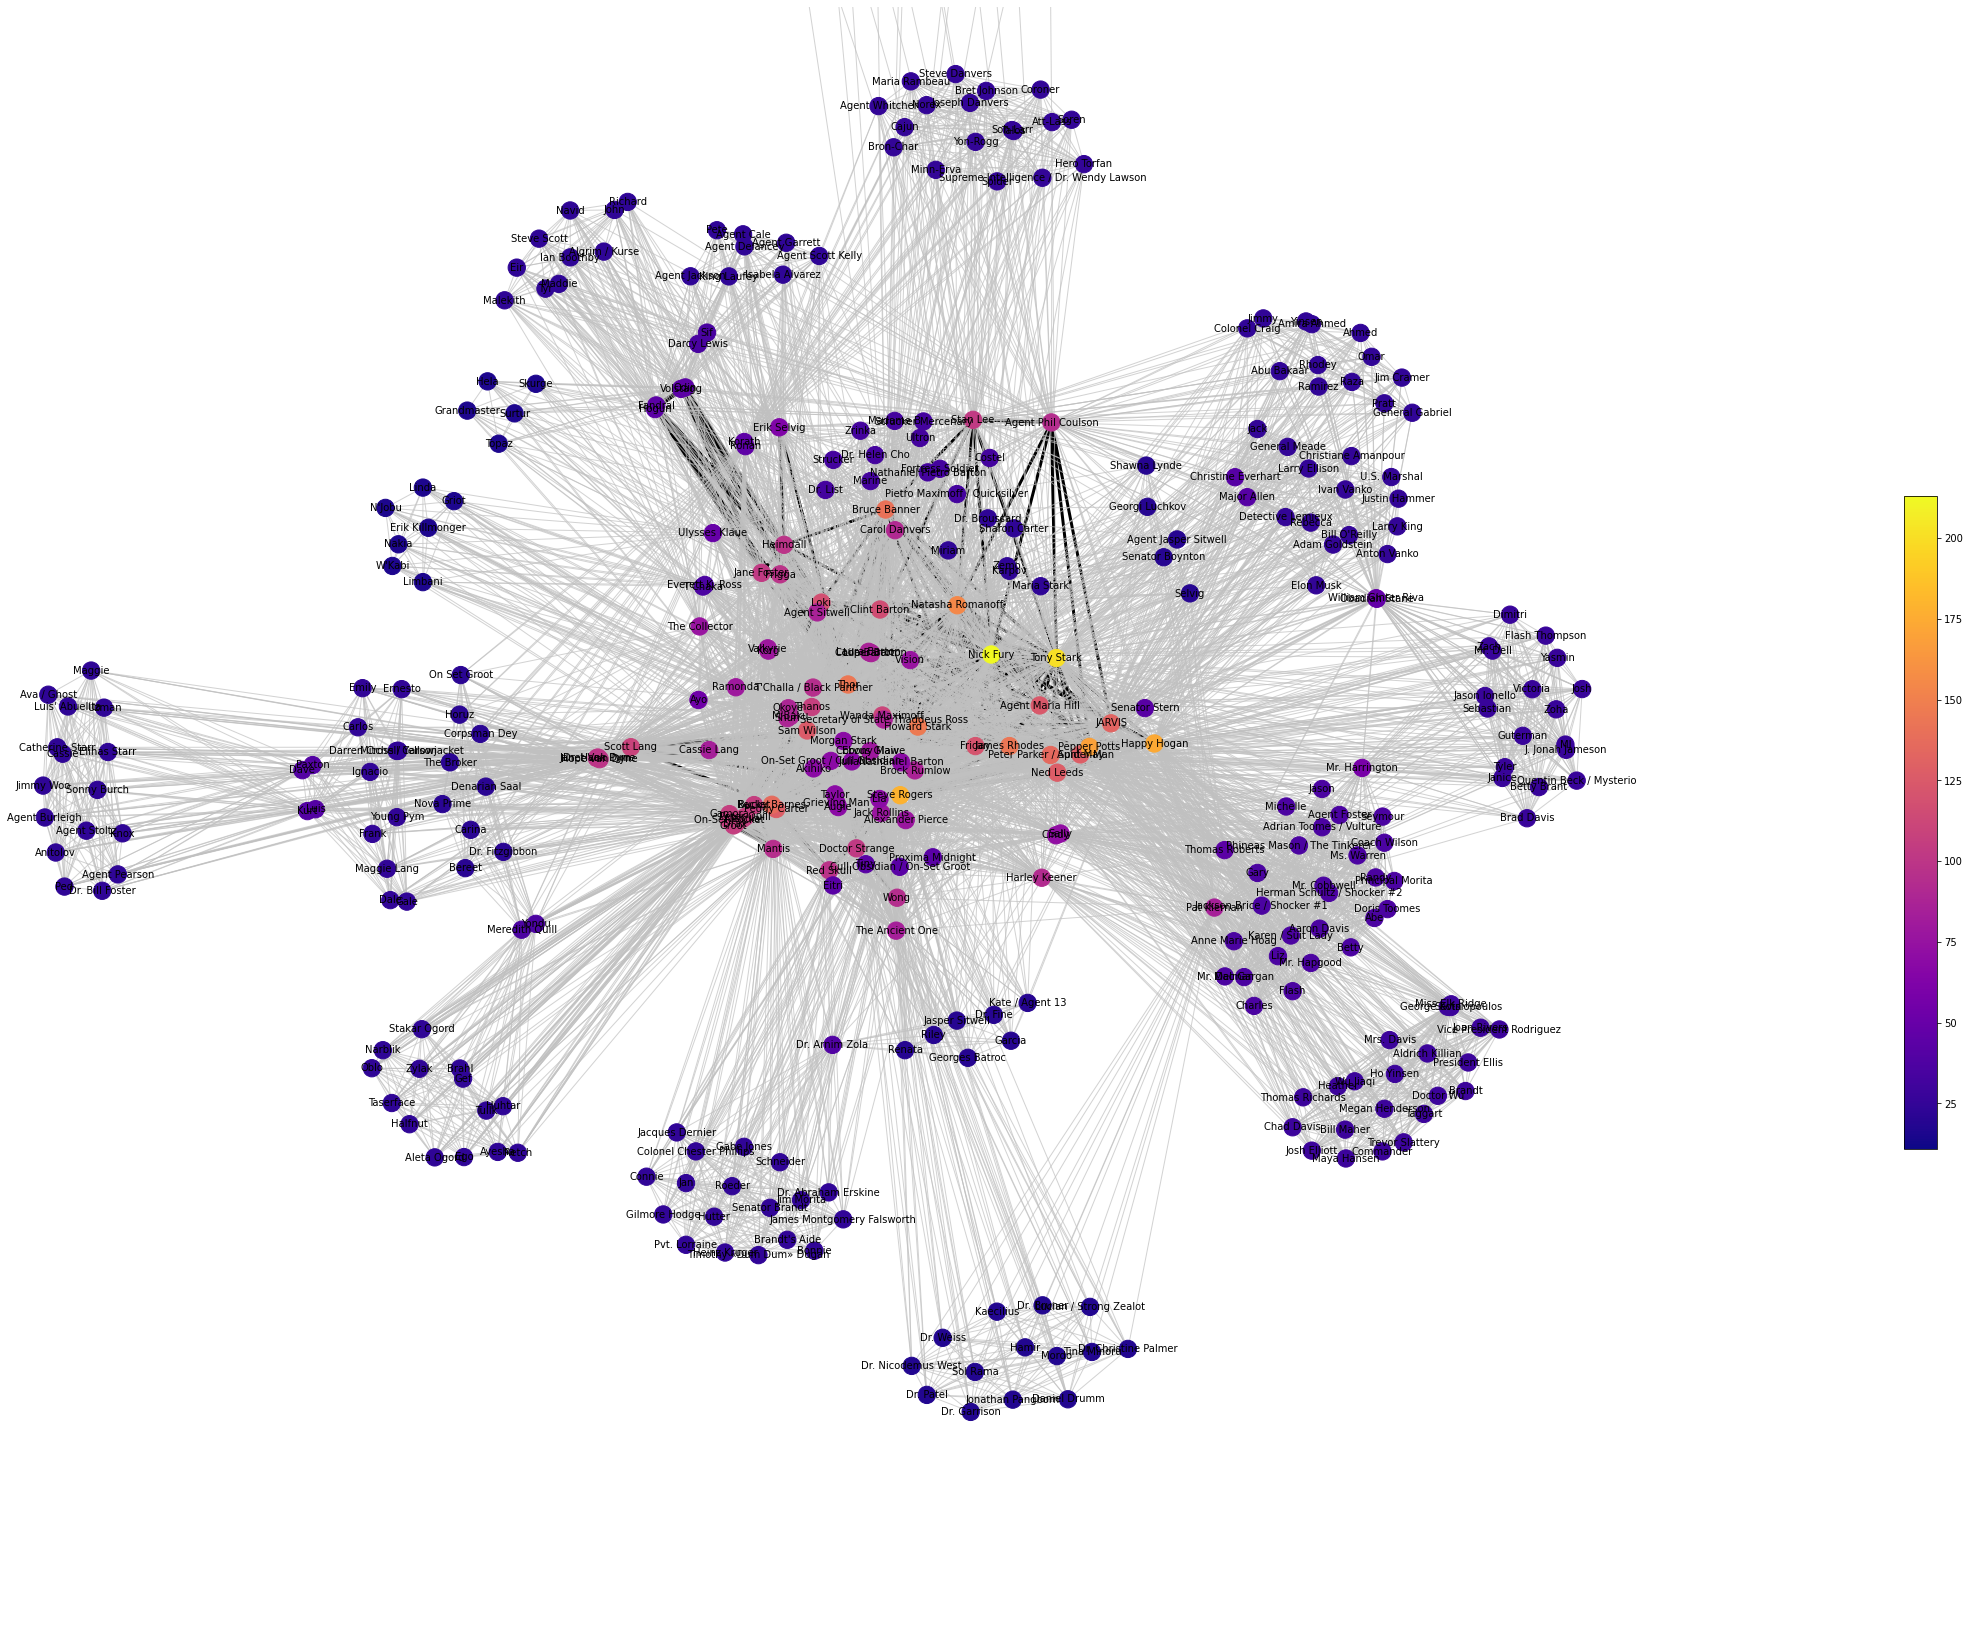

In [ ]:
# визуализируем полученный граф
# цвет узлов кодирует коээфициент degree
# цвет и толщину ребер кодирует вес связи

plt.figure(figsize=(40,30))

elarge = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] > 2]
esmall = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] <= 2]

dd = dict(g.degree)
node_colors = list(dd.values())

pos = nx.spring_layout(g)

nodes = nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=300, cmap='plasma')

nx.draw_networkx_edges(g, pos, edgelist=elarge, width=3.0)
nx.draw_networkx_edges(g, pos, edgelist=esmall, width=1.0, alpha=0.7, edge_color='silver')

nx.draw_networkx_labels(g, pos, font_size=10, font_family='sans-serif')

plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.xlim([-.95, 1.05])
plt.ylim([-1., .75])
plt.axis('off')
#plt.savefig('marvel_films_heroes.png')

##  Описательные статистики

Я подсчитала коэффициенты центральности и page rank для созданного графа. А также построила графики распределения для этих значений.

In [ ]:
# graph diameter
print('Graph diameter (D):', nx.diameter(g))

# average global clustering coefficient
print('Average global clustering coefficient:', nx.average_clustering(g))

# global clustering coefficient
print('Global clustering coefficient (C):', nx.transitivity(g))

Graph diameter (D): 3
Average global clustering coefficient: 0.8937656739160851
Global clustering coefficient (C): 0.5888626201822886


In [ ]:
# 5 nodes with max degree centrality
degree = nx.degree_centrality(g)
print((sorted(degree.keys(), key=lambda key:degree[key], reverse=True)[:5]))

['Nick Fury', 'Tony Stark', 'Steve Rogers', 'Happy Hogan', 'Pepper Potts']


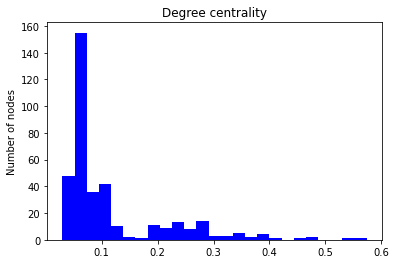

In [ ]:
#histogram with distribution of degree centrality
plt.title('Degree centrality')
plt.ylabel('Number of nodes')
plt.hist(list((degree.values())), 25, color = 'b')
#plt.show()
plt.savefig('marvel_films_degree_centrality.png')

In [ ]:
# 5 nodes with max betweenness centrality
betw = nx.betweenness_centrality(g)
print((sorted(betw.keys(), key=lambda key:betw[key], reverse=True)[:5]))

['Nick Fury', 'Tony Stark', 'Steve Rogers', 'Happy Hogan', 'Bruce Banner']


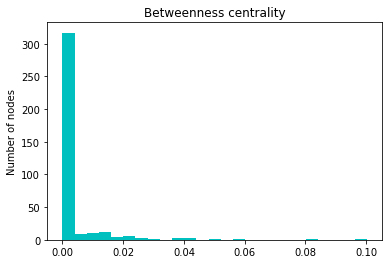

In [ ]:
#histogram with distribution of betweenness centrality
plt.title('Betweenness centrality')
plt.ylabel('Number of nodes')
plt.hist(list((betw.values())), 25, color = 'c')
#plt.show()
plt.savefig('marvel_films_betweeenness_centrality.png')

In [ ]:
# 5 nodes with max eigenvector centrality
eigen = nx.eigenvector_centrality(g)
print((sorted(eigen.keys(), key=lambda key:eigen[key], reverse=True)[:5]))

['Tony Stark', 'Nick Fury', 'Steve Rogers', 'Pepper Potts', 'Natasha Romanoff']


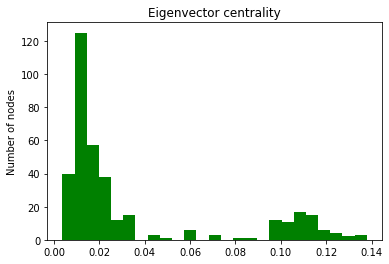

In [ ]:
#histogram with distribution of eigenvector centrality
plt.title('Eigenvector centrality')
plt.ylabel('Number of nodes')
plt.hist(list((eigen.values())), 25, color = 'g')
#plt.show()
plt.savefig('marvel_films_eigenvector_centrality.png')

In [ ]:
# 5 nodes with max page rank
pr = nx.pagerank(g, alpha=0.85)
print((sorted(pr.keys(), key=lambda key:pr[key], reverse=True)[:5]))

['Nick Fury', 'Tony Stark', 'Steve Rogers', 'Natasha Romanoff', 'Pepper Potts']


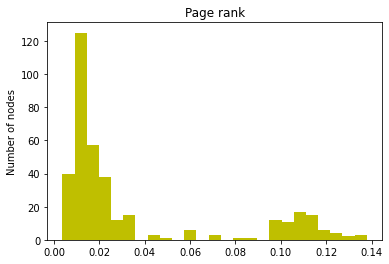

In [ ]:
#histogram with distribution of eigenvector centrality
plt.title('Page rank')
plt.ylabel('Number of nodes')
plt.hist(list((eigen.values())), 25, color = 'y')
#plt.show()
plt.savefig('marvel_films_page_rank.png')

## Проверка степенного закона

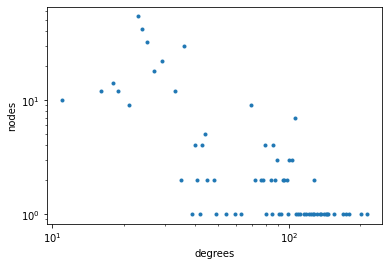

In [ ]:
degrees = np.array(list(dict(g.degree()).values()))
d = Counter(degrees)

plt.xlabel('degrees')
plt.ylabel('nodes')
plt.loglog(list(d.keys()), list(d.values()), '.', lw=2)
plt.show()

In [ ]:
def get_alpha(x_min):
    new_degrees = []
    for degree in degrees:
        if degree >= x_min:
            new_degrees.append(degree)

    n = len(new_degrees) + 0.0
    
    alpha = 0.0
    for degree in new_degrees:
        alpha = alpha + (np.log(degree / x_min))

    alpha = 1 + n / alpha
    
    return alpha

In [ ]:
x_min = 15.0
            
new_degrees = []
for degree in degrees:
    if degree >= x_min:
        new_degrees.append(degree)

n = len(new_degrees) + 0.0

alpha = 0.0
for degree in new_degrees:
    alpha = alpha + (np.log(degree / x_min))

alpha = 1 + n / alpha

alpha = get_alpha(x_min)
sigma = (alpha - 1) / np.sqrt(n)

print('Estimated alpha:', alpha)
print('Sigma squared:', sigma)

Estimated alpha: 2.1826480669663963
Sigma squared: 0.062158602394645865


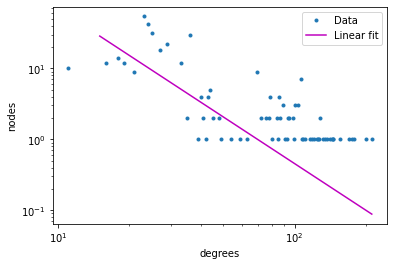

In [ ]:
c = Counter(new_degrees)

C = (alpha - 1) * (x_min ** (alpha - 1))

def f(x):
    return C * (x ** (-alpha)) * n
x = np.arange(x_min, max(degrees), 1)

data, = plt.loglog(list(d.keys()), list(d.values()), '.', lw=2, label = 'Data')
fit,  = plt.loglog(x, f(x), 'm', label = 'Linear fit')
plt.xlabel('degrees')
plt.ylabel('nodes')
plt.legend(handles = [data, fit])
plt.show()